# Import Data

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math as math
import matplotlib as mpl
import scikitplot as skplt

sns.set(style="white", palette="pastel",font_scale=1.5, rc={"lines.linewidth": 2.5,'figure.figsize':(11.7,8.27)})
pd.options.display.max_columns = None

In [28]:
# some general parameters for plots
mpl.rcParams['axes.linewidth'] = 2.5
mpl.rcParams['axes.edgecolor'] = "grey"
mpl.rcParams['figure.edgecolor'] = "grey"
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['legend.edgecolor'] = "grey"
mpl.rcParams['legend.shadow'] = False
mpl.rcParams["legend.framealpha"] = 1
mpl.rcParams['font.weight'] = "bold"
mpl.rcParams['axes.labelweight'] = "bold"
mpl.rcParams['axes.titleweight'] = "bold"

In [2]:
import utils as ut

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier,StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

In [4]:
df_not_combined = pd.read_csv("data/exported/df_not_combined.csv", index_col = 0)
df_yeast_not_combined = pd.read_csv("data/exported/df_yeast_not_combined.csv", index_col = 0)

In [5]:
df_not_combined = df_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category","modified_status":"category"})
df_not_combined = df_not_combined.astype({"ref_number":"object"})

In [6]:
df_yeast_not_combined = df_yeast_not_combined.astype({"base_1":"category","base_2":"category","base_3":"category",\
                                          "base_4":"category","base_5":"category"})
df_yeast_not_combined = df_yeast_not_combined.astype({"ref_number":"object"})

# train test split

In [7]:
# manual train test split according to ref_num to preserve sequence sequence identity
# maybe do it according to read_num to increase variability?

final_ref = ["ref_0000","ref_0001","ref_0002","ref_0003"]
val_ref = ["ref_0004"]
#train_ref = ["ref_0000","ref_0001","ref_0002"]
#test_ref = ["ref_0003"]

In [8]:
seed = 7

## not_combined

In [9]:
# x and y dataframes for each combination for each train test split combo
X_finaltest_not_combined = df_not_combined[df_not_combined["ref_number"].isin(final_ref)]
y_finaltest_not_combined = X_finaltest_not_combined.pop("modified_status")
X_val_not_combined = df_not_combined[df_not_combined["ref_number"].isin(val_ref)]
y_val_not_combined = X_val_not_combined.pop("modified_status")
#X_train_not_combined = df_not_combined[df_not_combined["ref_number"].isin(train_ref)]
#y_train_not_combined = X_train_not_combined.pop("modified_status")
#X_test_not_combined = df_not_combined[df_not_combined["ref_number"].isin(test_ref)]
#y_test_not_combined = X_test_not_combined.pop("modified_status")

In [10]:
# prepare list of numeric and categorical features to feed into column transformer

numeric_features_not_combined = list(X_finaltest_not_combined.columns[X_finaltest_not_combined.dtypes ==  "float"])

In [11]:
numeric_features_not_combined

['dwell_time',
 'median_value',
 'dwell_time_rolling_median',
 'median_value_rolling_median',
 'dwell_time_rolling_min',
 'median_value_rolling_min',
 'dwell_time_diff_to_median',
 'median_value_diff_to_median']

In [12]:
cat_features_not_combined = list(X_finaltest_not_combined.columns[X_finaltest_not_combined.dtypes ==  "category"])

In [13]:
cat_features_not_combined

['base_1', 'base_2', 'base_3', 'base_4', 'base_5']

In [14]:
#preprocessing pipeline to scale numeric and onehot encode categorical values
imputer1_not_combined = SimpleImputer(strategy="median")
scaler1_not_combined = StandardScaler()
numeric_transformer_not_combined = make_pipeline(imputer1_not_combined,scaler1_not_combined)


imputer2_not_combined = SimpleImputer(strategy='constant', fill_value='missing')
encoder_not_combined = OneHotEncoder(handle_unknown='error')
cat_transformer_not_combined = make_pipeline(imputer2_not_combined,encoder_not_combined)

preprocessor_not_combined = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_not_combined, numeric_features_not_combined),
        ('cat', cat_transformer_not_combined, cat_features_not_combined)
    ])

### preprocessor without bases

In [15]:
#preprocessing pipeline to scale numeric and onehot encode categorical values
# ignore bases

preprocessor_not_combined_wo_bases = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_not_combined, numeric_features_not_combined)
    ])

### limitation preprocessor

In [16]:
numeric_features_limited = ["dwell_time","dwell_time_rolling_min","dwell_time_diff_to_median"]

In [17]:
# only select 3 values (most important ones)


preprocessor_not_combined_limited = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_not_combined, numeric_features_limited)
    ])

# combined data frame

In [18]:
# prepare empty dataframes for result collection

model_selection_results = pd.DataFrame()
yeast_prediction_results = pd.DataFrame()

In [19]:
# cv by hand produces 4 fits singling each of the four remaining dna strands out each time, to provide
# realistic cross validation

labels = X_finaltest_not_combined.ref_number.values
cv_by_hand = [(np.where(labels != label)[0], np.where(labels == label)[0])
               for label in np.unique(labels)]

## baseline

In [20]:
# baseline model with all zeros, as data is rather imbalanced
y_pred = np.zeros(len(X_val_not_combined))

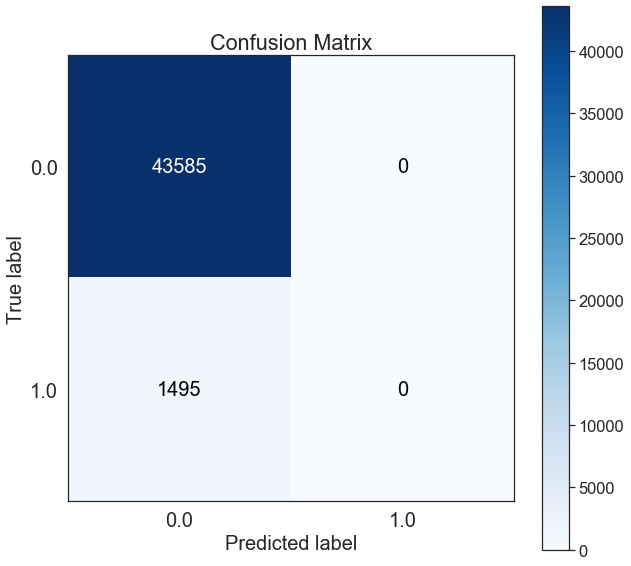

In [21]:
skplt.metrics.plot_confusion_matrix(y_val_not_combined, y_pred, figsize=(10,10), text_fontsize=20)

In [22]:
print(classification_report(y_val_not_combined,y_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     43585
         1.0       0.00      0.00      0.00      1495

    accuracy                           0.97     45080
   macro avg       0.48      0.50      0.49     45080
weighted avg       0.93      0.97      0.95     45080



C:\Users\neomo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## classical ml models

### model selection

In [23]:
# first model selection on whole dataset using model selector class (found in utilities.py)
sel = ut.ModelSelector(preprocessor_not_combined, instance_name = "Uncombined Dataframe")

In [24]:
sel.select_model(X_finaltest_not_combined, y_finaltest_not_combined, True)

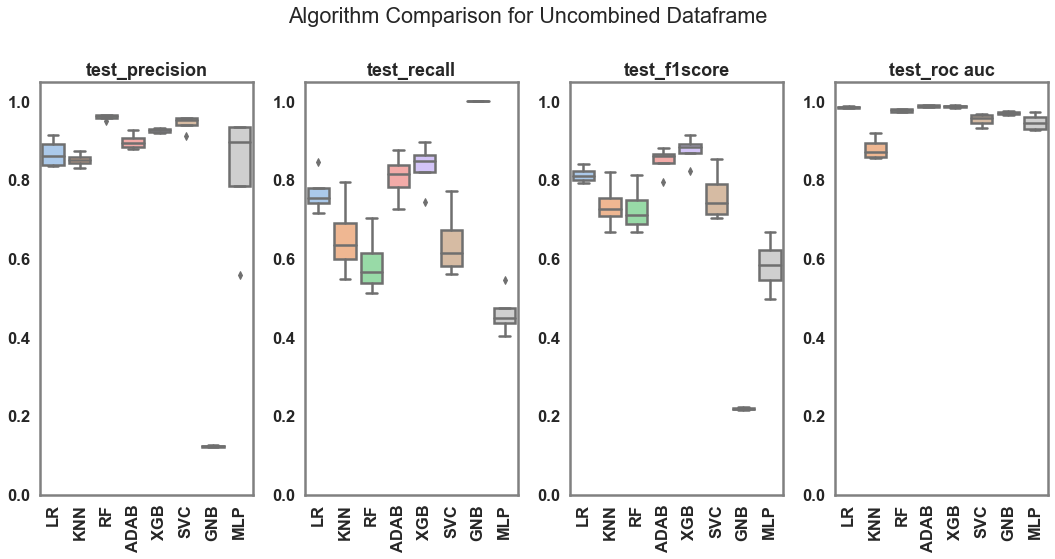

In [29]:
sel.plot_selection()
plt.savefig("figures/data_viz/6.png",dpi=300,bbox_inches="tight", transparent= True);

In [26]:
model_selection_results = pd.concat([model_selection_results,sel.get_scores()], axis=0)

### xgb gridsearch

In [31]:
#xgb hast best f1 score, so this one is used in grid search, parameter in grid represent best ones found
param_grid_xgb = {'xgbclassifier__max_depth':[1],
                 'xgbclassifier__learning_rate':[0.2],
                 'xgbclassifier__n_estimators':[1000],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [32]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = make_pipeline(preprocessor_not_combined,xgb_clf)

In [33]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   26.5s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 1000}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43585
         1.0       0.91      0.85      0.88      1495

    accuracy                           0.99     45080
   macro avg       0.95      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :45.22
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :45.22
Ratio of modified Reads for ref_pos 169 is :31.74
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified Reads for ref_pos 185 is :41.74
-----------------

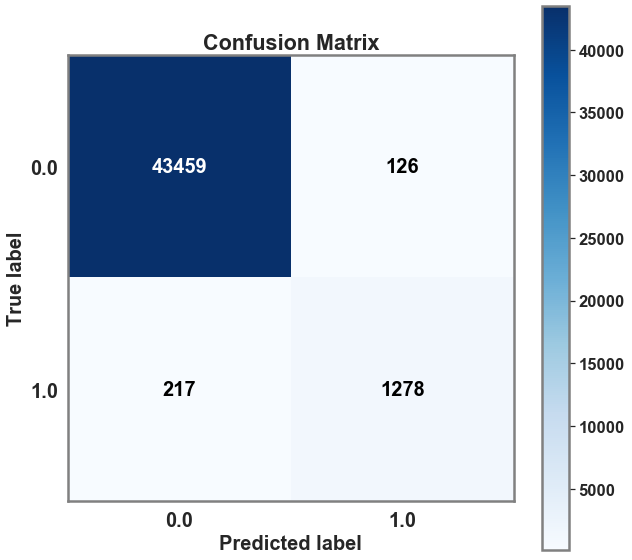

In [34]:
modified_ratio_uncombined = ut.evaluation(grid_xgb, X_val_not_combined, y_val_not_combined)
plt.savefig("figures/data_viz/7.png",dpi=300,bbox_inches="tight", transparent= True);

### ADABoost Gridsearch

In [31]:
# adaboost = second best one, also optimized for stacking applications
param_grid_ada = {'adaboostclassifier__algorithm':['SAMME.R'],
                  'adaboostclassifier__learning_rate':[0.05],
                 'adaboostclassifier__n_estimators':[100]}

In [32]:
ada_clf = AdaBoostClassifier(random_state=seed)
model_ada = make_pipeline(preprocessor_not_combined,ada_clf)

In [33]:
grid_ada = GridSearchCV(model_ada, param_grid_ada, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_ada.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_ada.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   33.5s finished


{'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__learning_rate': 0.05, 'adaboostclassifier__n_estimators': 100}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     43585
         1.0       0.91      0.85      0.88      1495

    accuracy                           0.99     45080
   macro avg       0.95      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :44.78
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :35.22
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :40.87
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :39.57
Ratio of modified Reads for ref_pos 169 is :36.52
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified 

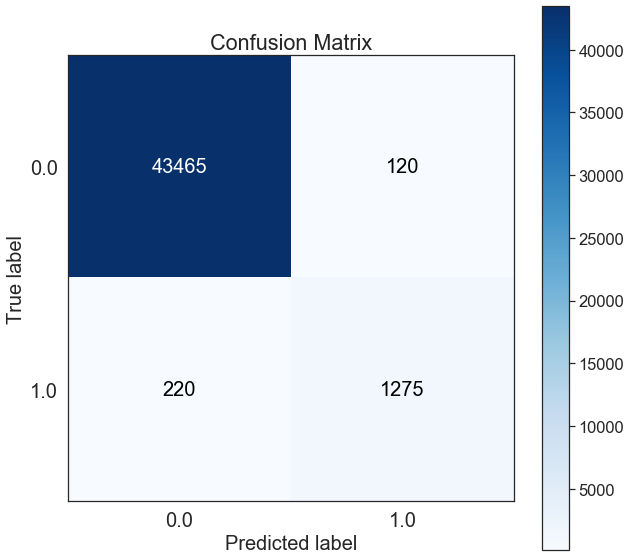

In [34]:
modified_ratio_uncombined_ada = ut.evaluation(grid_ada, X_val_not_combined, y_val_not_combined)

### logit gridsearch

In [35]:
# logistic regression = third best one, also optimized for stacking applications

class_weight_list = compute_class_weight("balanced", df_not_combined.modified_status.unique(),df_not_combined.modified_status.values) 
class_weight = dict(zip(df_not_combined.modified_status.unique(), class_weight_list))

In [36]:
param_grid_logit = {'logisticregression__penalty':['l1'],
                    'logisticregression__dual':[False],
                    'logisticregression__tol':[0.0001],
                    'logisticregression__C':[2.0],
                    'logisticregression__fit_intercept':[False],
                    'logisticregression__class_weight':[None],
                    'logisticregression__solver':['liblinear']
                   }

In [37]:
logit_clf = LogisticRegression(random_state=seed, max_iter = 1000, n_jobs=-1)
model_logit = make_pipeline(preprocessor_not_combined,logit_clf)

In [38]:
grid_logit = GridSearchCV(model_logit, param_grid_logit, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_logit.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_logit.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   16.3s finished
C:\Users\neomo\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


{'logisticregression__C': 2.0, 'logisticregression__class_weight': None, 'logisticregression__dual': False, 'logisticregression__fit_intercept': False, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear', 'logisticregression__tol': 0.0001}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     43585
         1.0       0.87      0.79      0.82      1495

    accuracy                           0.99     45080
   macro avg       0.93      0.89      0.91     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.65
Ratio of modified Reads for ref_pos 43 is :44.78
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 75 is :38.7
Ratio of modified Reads for ref_pos 81 is :45.65
Ratio of modified Reads for ref_pos 104 is :44.78
Ratio of modified Reads for ref_pos 123 is :43.48
Ratio of modified Reads for ref_pos 163 is :45.22
Ratio of modified Reads for ref_pos 179 is :44.78
Ratio of modified Reads for ref_pos 185 is :44.35
------------------------------


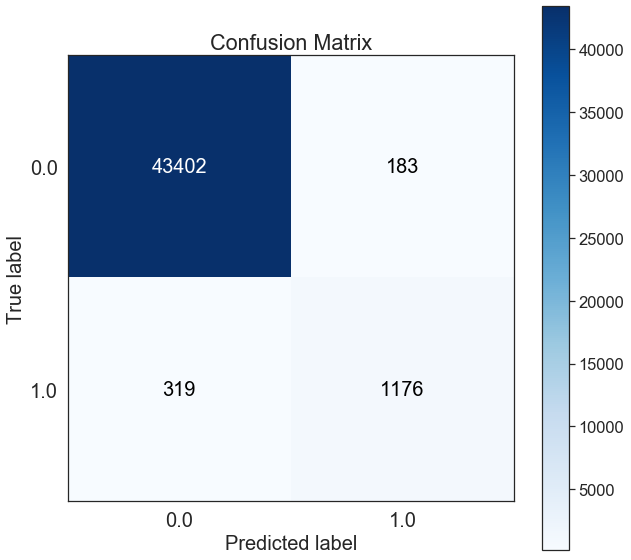

In [39]:
modified_ratio_uncombined_logit = ut.evaluation(grid_logit, X_val_not_combined, y_val_not_combined)

### Stacking

In [40]:
# stacking for three best models, using logit as final estimator

In [41]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed, max_depth=1, learning_rate=0.2, n_estimators=500, gamma=0)
model_xgb = make_pipeline(preprocessor_not_combined,xgb_clf)

In [42]:
ada_clf = AdaBoostClassifier(random_state=seed, n_estimators=60, learning_rate=0.05)
model_ada = make_pipeline(preprocessor_not_combined,ada_clf)

In [43]:
logit_clf = LogisticRegression(random_state=seed, max_iter = 1000, n_jobs=-1, penalty='l1', tol=0.001, C=2.0, fit_intercept=False, solver='liblinear')
model_logit = make_pipeline(preprocessor_not_combined,logit_clf)

In [44]:
estimators = [("XGB", model_xgb),("ADA",model_ada),("logit",model_logit)]
stack_clf = StackingClassifier(estimators, cv = cv_by_hand, final_estimator = LogisticRegression(), n_jobs=-1)

In [45]:
%%capture
stack_clf.fit(X_finaltest_not_combined, y_finaltest_not_combined)

------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43585
         1.0       0.91      0.86      0.89      1495

    accuracy                           0.99     45080
   macro avg       0.95      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :31.74
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :44.35
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :43.91
Ratio of modified Reads for ref_pos 169 is :35.22
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified 

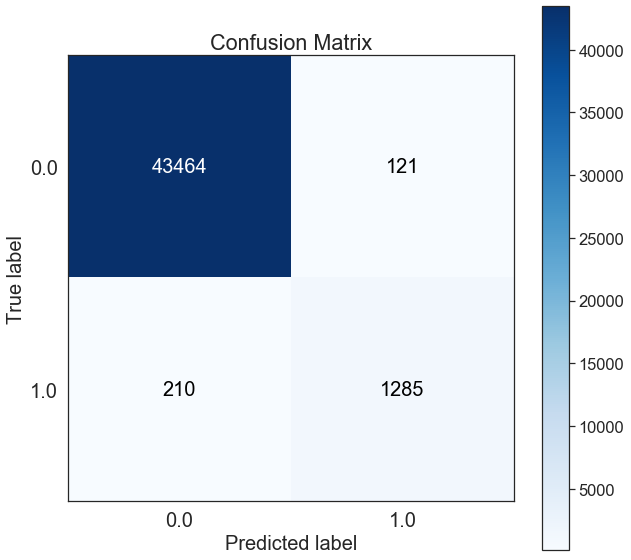

In [46]:
modified_ratio_uncombined_stack = ut.evaluation(stack_clf, X_val_not_combined, y_val_not_combined)

### Voting

In [47]:
# voting approach for three best models, hard voting provides better results than soft voting
vote_clf = VotingClassifier(estimators, n_jobs=-1, voting='hard')

In [48]:
%%capture
vote_clf.fit(X_finaltest_not_combined, y_finaltest_not_combined)

------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43585
         1.0       0.92      0.86      0.89      1495

    accuracy                           0.99     45080
   macro avg       0.96      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :30.43
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :45.22
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :44.78
Ratio of modified Reads for ref_pos 169 is :33.48
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified 

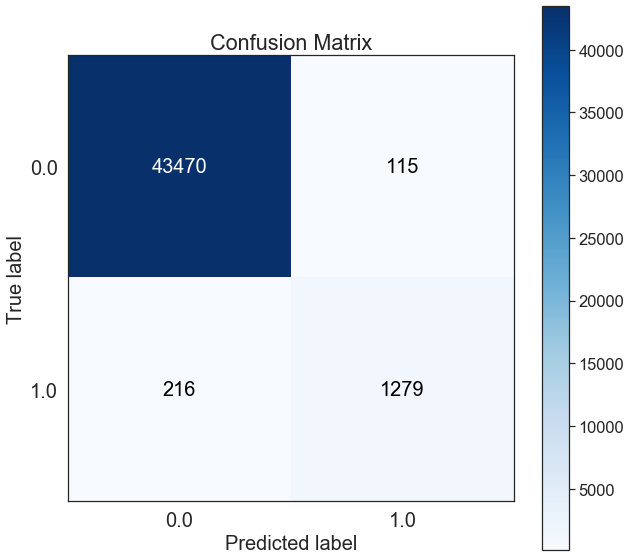

In [49]:
modified_ratio_uncombined_vote = ut.evaluation(vote_clf, X_val_not_combined, y_val_not_combined)

### feature importances

In [35]:
xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.2,
                        max_depth= 1, n_estimators = 1000)

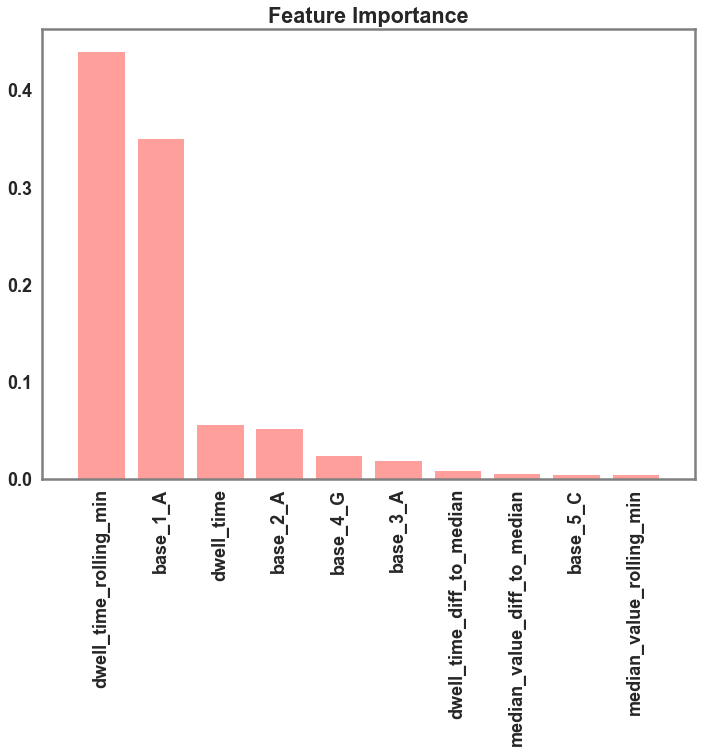

In [36]:
ut.feature_importances(xgb, preprocessor_not_combined, X_finaltest_not_combined, y_finaltest_not_combined)
plt.savefig("figures/data_viz/8.png",dpi=300,bbox_inches="tight", transparent= True);

### yeast dataset prediction

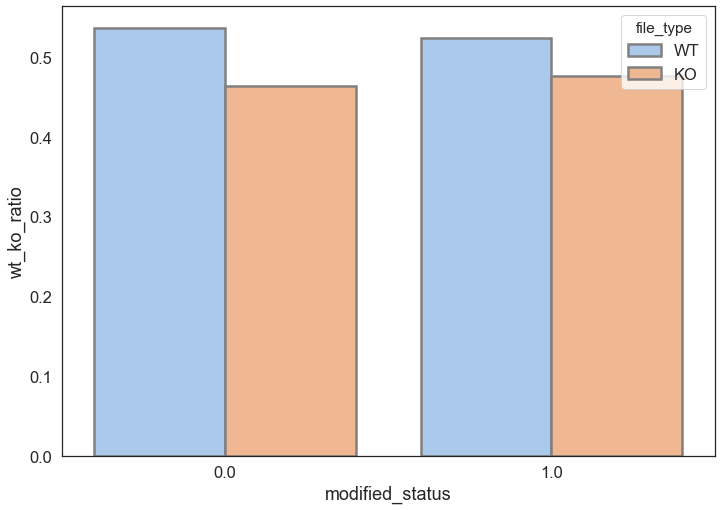

In [52]:
# full model not that useful for yeast data
temp = ut.yeast_prediction(preprocessor_not_combined, X_finaltest_not_combined, 
                 y_finaltest_not_combined, df_yeast_not_combined, xgb, "Not Combined")
yeast_prediction_results = pd.concat([yeast_prediction_results,temp], axis=0)

## Classical ml models with Oversampling

In [53]:
# try to improve with oversampling using smotetomek
smotet = SMOTETomek(sampling_strategy = 'minority', random_state = seed, n_jobs = -1)


### model selection

In [54]:
sel_os = ut.ModelSelector(preprocessor_not_combined, smotet, instance_name = "Uncombined Dataframe and Oversampling")

sel_os.select_model(X_finaltest_not_combined, y_finaltest_not_combined, True)

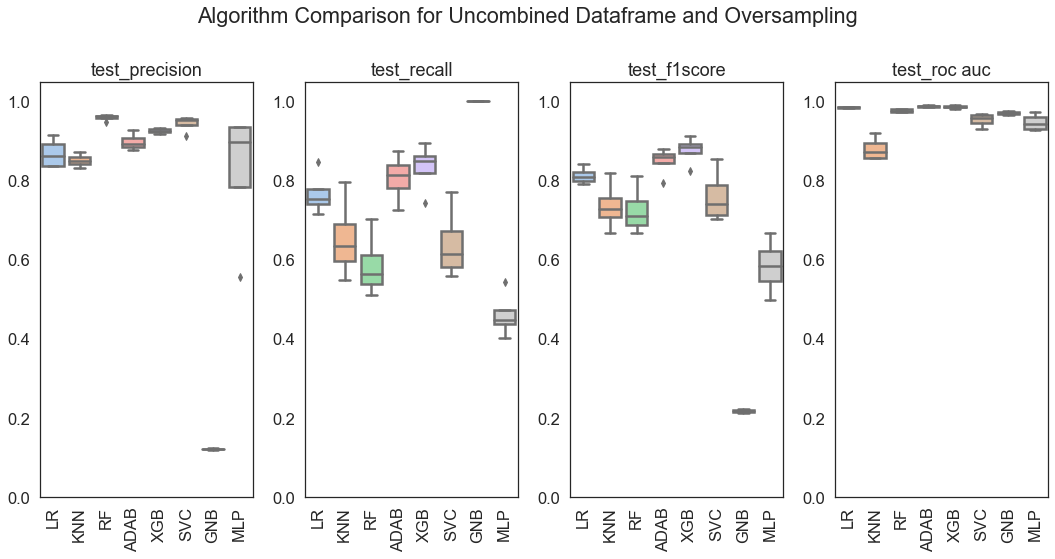

In [55]:
sel_os.plot_selection()

In [56]:
model_selection_results = pd.concat([model_selection_results,sel_os.get_scores()], axis=0)

### xgb gridsearch

In [57]:
param_grid_xgb = {'xgbclassifier__max_depth':[5],
                 'xgbclassifier__learning_rate':[0.1],
                 'xgbclassifier__n_estimators':[5],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [58]:
xgb_clf = XGBClassifier(n_jobs = -1,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_not_combined),("smt",smotet),("xgbclassifier",xgb_clf)])

In [59]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   31.5s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 5}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     43585
         1.0       0.84      0.91      0.87      1495

    accuracy                           0.99     45080
   macro avg       0.92      0.95      0.93     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.65
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :45.65
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :45.22
Ratio of modified Reads for ref_pos 104 is :45.65
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :45.22
Ratio of modified Reads for ref_pos 169 is :45.22
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified 

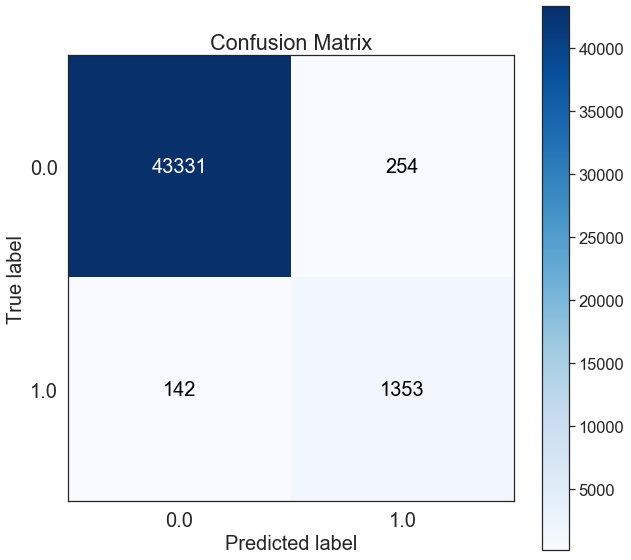

In [60]:
# better recall, worse precision, overall f1-score similar
modified_ratio_uncombined_os = ut.evaluation(grid_xgb, X_val_not_combined, y_val_not_combined)

In [61]:
# improvement in recall, but worse precision, depends on what you are loooking fore if its worth it

## Classical ml models (dwell time polynomial)

In [62]:
# dwell time seems to be most important, so add a 1 and do polynomials to increase differnces
# seems to make no difference (as seen in feature importances, polynomial features are not used)
poly = PolynomialFeatures(10)

In [63]:
X_poly = np.array(df_not_combined.dwell_time + 1)
X_poly = pd.DataFrame(poly.fit_transform(X_poly.reshape(-1,1)))
cols = ["dwell_time_poly_" + str(elm) for elm in list(X_poly.columns)]
X_poly.columns = cols
df_poly = pd.concat([df_not_combined, X_poly], axis = 1)

In [65]:
X_finaltest_poly = df_poly[df_poly["ref_number"].isin(final_ref)]
y_finaltest_poly = X_finaltest_poly.pop("modified_status")
X_val_poly = df_poly[df_poly["ref_number"].isin(val_ref)]
y_val_poly = X_val_poly.pop("modified_status")
#X_train_poly = df_poly[df_poly["ref_number"].isin(train_ref)]
#y_train_poly = X_train_poly.pop("modified_status")
#X_test_poly = df_poly[df_poly["ref_number"].isin(test_ref)]
#y_test_poly = X_test_poly.pop("modified_status")

In [67]:
numeric_features_poly = list(X_finaltest_poly.columns[X_finaltest_poly.dtypes ==  "float"])

In [68]:
cat_features_poly = list(X_finaltest_poly.columns[X_finaltest_poly.dtypes ==  "category"])

In [69]:
#preprocessing pipeline to scale numeric and onehot encode categorical values
imputer1_poly = SimpleImputer(strategy="median")
scaler1_poly = StandardScaler()
numeric_transformer_poly = make_pipeline(imputer1_poly,scaler1_poly)


imputer2_poly = SimpleImputer(strategy='constant', fill_value='missing')
encoder_poly = OneHotEncoder(handle_unknown='error')
cat_transformer_poly = make_pipeline(imputer2_poly,encoder_poly)

preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_features_poly),
        ('cat', cat_transformer_poly, cat_features_poly)
    ])

### model selection

In [70]:
sel_poly = ut.ModelSelector(preprocessor_poly, instance_name = "Uncombined Dataframe and Polynomial Dwell Time")

sel_poly.select_model(X_finaltest_poly, y_finaltest_poly, True)

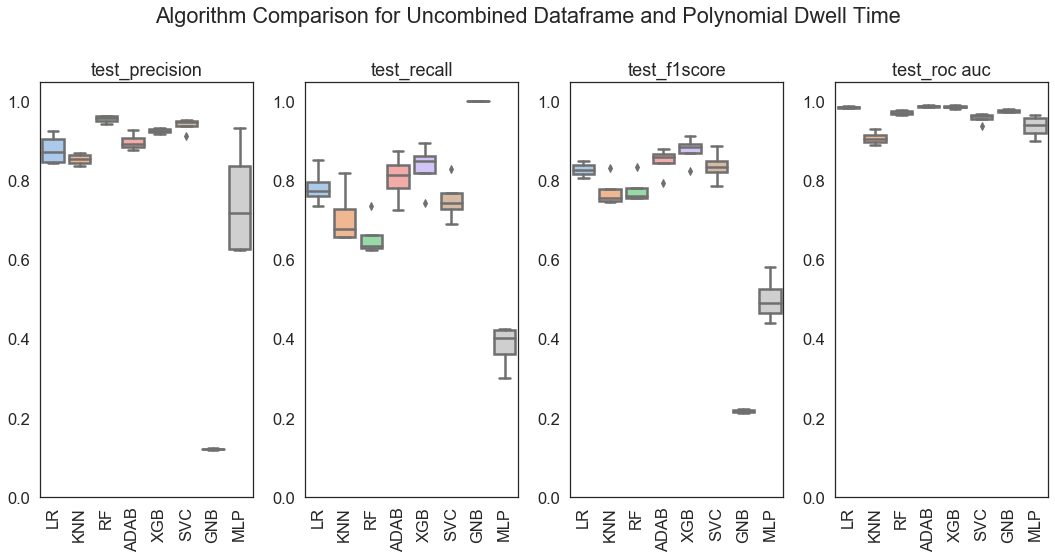

In [71]:
sel_poly.plot_selection()

In [72]:
model_selection_results = pd.concat([model_selection_results,sel_poly.get_scores()], axis=0)

### xgb gridsearch

In [73]:
param_grid_xgb = {'xgbclassifier__max_depth':[1],
                 'xgbclassifier__learning_rate':[0.2],
                 'xgbclassifier__n_estimators':[500],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [74]:
xgb_clf = XGBClassifier(n_jobs = -1,random_state=seed)
model_xgb = Pipeline([("transformer",preprocessor_poly),("xgbclassifier",xgb_clf)])

In [75]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_poly, y_finaltest_poly)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   39.6s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 500}


------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     43585
         1.0       0.91      0.86      0.88      1495

    accuracy                           0.99     45080
   macro avg       0.95      0.93      0.94     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :45.22
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :31.3
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :45.22
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :44.78
Ratio of modified Reads for ref_pos 169 is :32.61
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified R

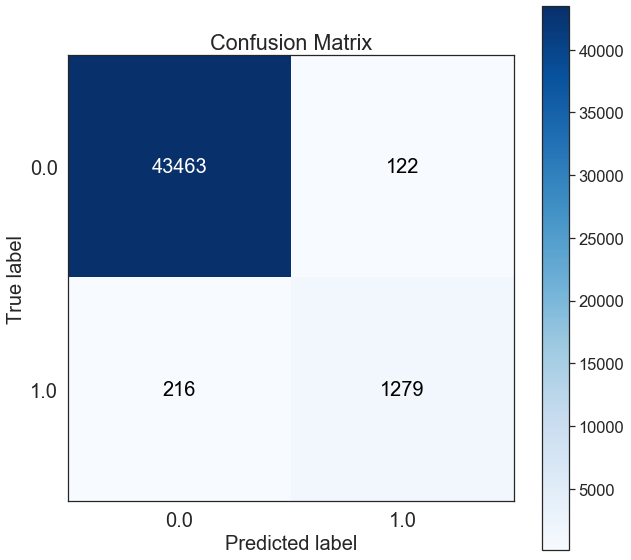

In [76]:
modified_ratio_uncombined_poly = ut.evaluation(grid_xgb, X_val_poly, y_val_poly)

### feature importances

In [77]:
xgb = XGBClassifier(n_jobs=4,random_state=seed, gamma= 0, learning_rate = 0.2,
                        max_depth= 1, n_estimators = 500)

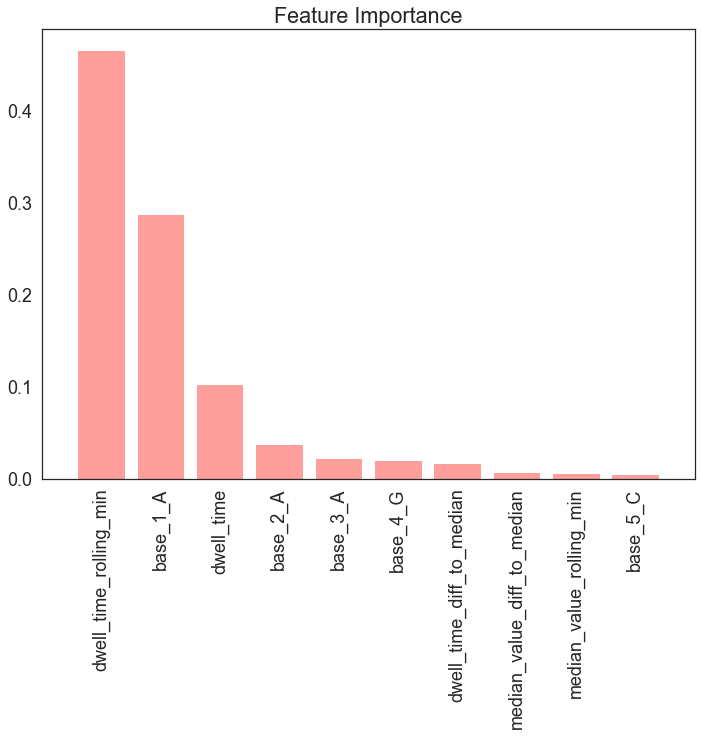

In [78]:
ut.feature_importances(xgb, preprocessor_poly, X_finaltest_poly, y_finaltest_not_combined)

## classical models without bases

In [79]:
# remove base information during preprocessing, as the treatment used for modification should not have a base specificity
# (which is in the data, every modified string starts with an A)

### model selection

In [80]:
sel_wo_bases = ut.ModelSelector(preprocessor_not_combined_wo_bases, instance_name = "Uncombined Dataframe without bases")

In [81]:
sel_wo_bases.select_model(X_finaltest_not_combined, y_finaltest_not_combined, True)

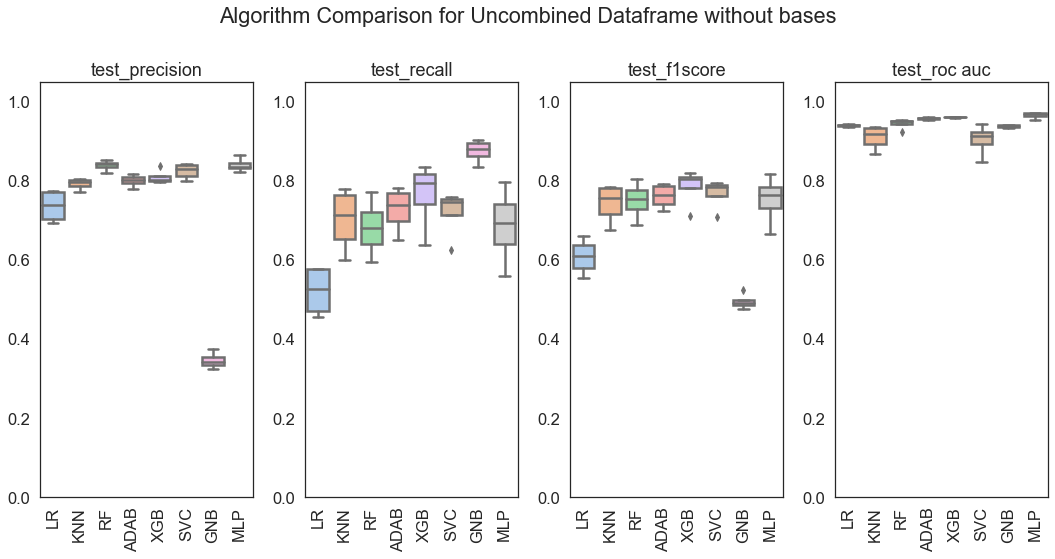

In [82]:
sel_wo_bases.plot_selection()

In [83]:
model_selection_results = pd.concat([model_selection_results,sel_wo_bases.get_scores()], axis=0)

### xgb gridsearch

In [84]:
param_grid_xgb = {'xgbclassifier__max_depth':[1],
                 'xgbclassifier__learning_rate':[0.2],
                 'xgbclassifier__n_estimators':[250],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [85]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = make_pipeline(preprocessor_not_combined_wo_bases,xgb_clf)

In [86]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.3s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 250}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     43585
         1.0       0.79      0.81      0.80      1495

    accuracy                           0.99     45080
   macro avg       0.89      0.90      0.90     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :39.57
Ratio of modified Reads for ref_pos 43 is :44.78
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :30.43
Ratio of modified Reads for ref_pos 75 is :44.35
Ratio of modified Reads for ref_pos 81 is :44.35
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :45.22
Ratio of modified Reads for ref_pos 163 is :36.96
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified Reads for ref_pos 185 is :35.22
------------------

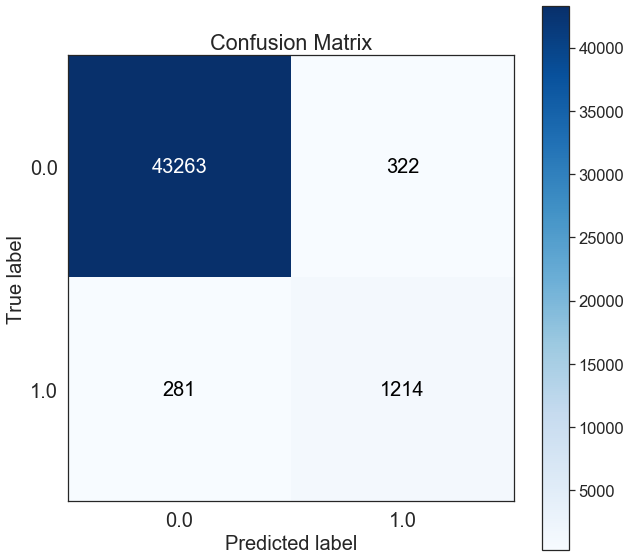

In [87]:
modified_ratio_uncombined_wo_bases = ut.evaluation(grid_xgb, X_val_not_combined, y_val_not_combined)

### feature importances

In [88]:
xgb = XGBClassifier(n_jobs=-1,random_state=seed, gamma = 0, learning_rate = 0.2, max_depth = 1, n_estimators = 250)

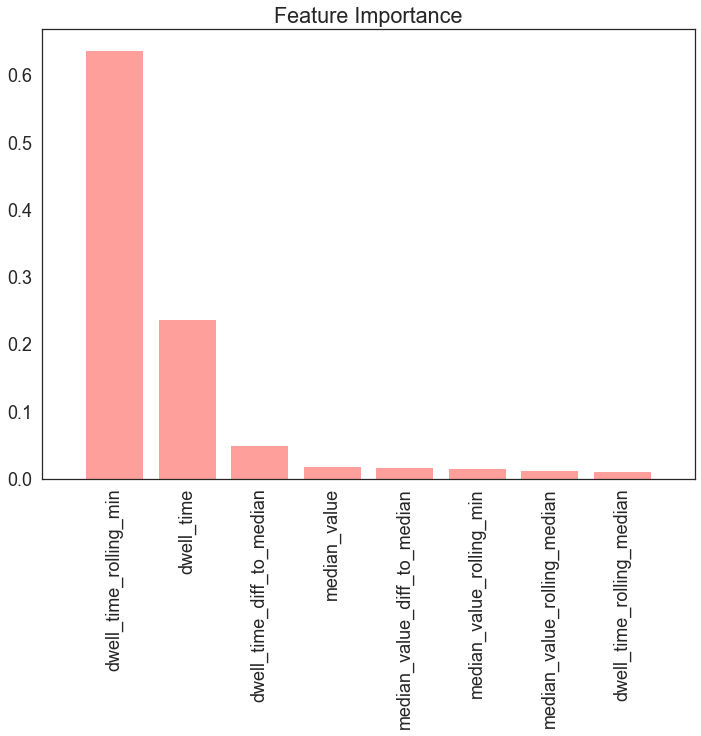

In [89]:
ut.feature_importances(xgb, preprocessor_not_combined_wo_bases, X_finaltest_not_combined, y_finaltest_not_combined)

### yeast dataset

In [90]:
# removing bases improves yeast prediction, seemingly proving that the base specificty in dataset seems to be artificial

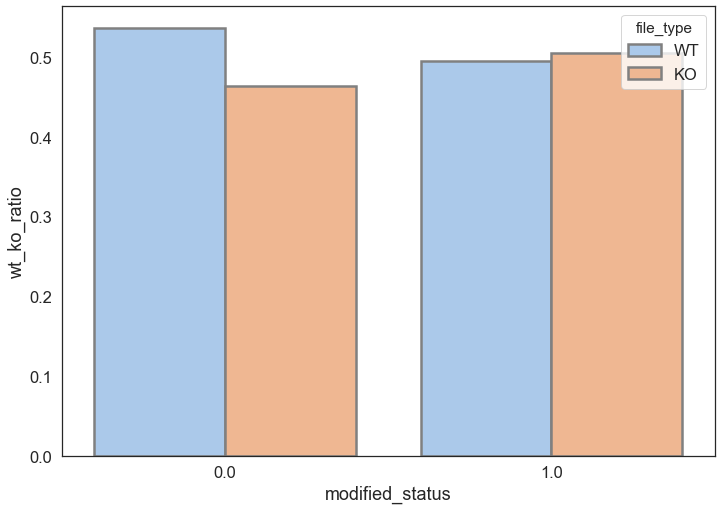

In [91]:
temp = ut.yeast_prediction(preprocessor_not_combined_wo_bases, X_finaltest_not_combined, 
                 y_finaltest_not_combined, df_yeast_not_combined, xgb, "Not Combined without Bases")
yeast_prediction_results = pd.concat([yeast_prediction_results,temp], axis=0)

## classical models limited

In [92]:
# more limited featureset, only using dwell_time_rolling_min, dwell_time and dwell_time_diff_to_median as they are
# the most important features ignoring bases

### model selection

In [93]:
sel_limited = ut.ModelSelector(preprocessor_not_combined_limited, instance_name = "Uncombined Dataframe limited")

In [94]:
sel_limited.select_model(X_finaltest_not_combined, y_finaltest_not_combined, True)

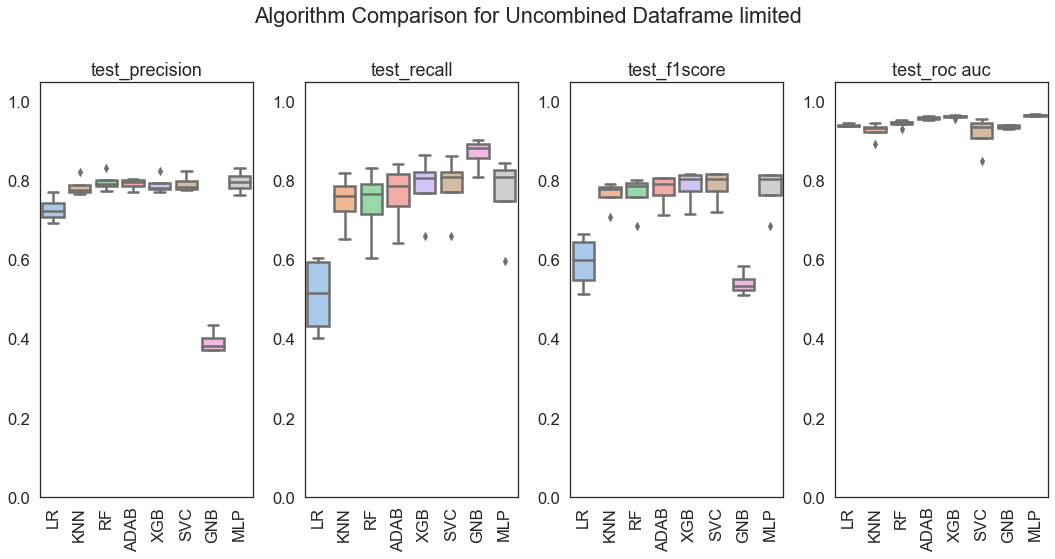

In [95]:
sel_limited.plot_selection()

In [96]:
model_selection_results = pd.concat([model_selection_results,sel_limited.get_scores()], axis=0)

### xgb gridsearch

In [97]:
param_grid_xgb = {'xgbclassifier__max_depth':[1],
                 'xgbclassifier__learning_rate':[0.1],
                 'xgbclassifier__n_estimators':[500],
                 'xgbclassifier__booster':["gbtree"],
                 'xgbclassifier__gamma':[0]}

In [98]:
xgb_clf = XGBClassifier(n_jobs=4,random_state=seed)
model_xgb = make_pipeline(preprocessor_not_combined_limited,xgb_clf)

In [99]:
grid_xgb = GridSearchCV(model_xgb, param_grid_xgb, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_xgb.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_xgb.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    7.3s finished


{'xgbclassifier__booster': 'gbtree', 'xgbclassifier__gamma': 0, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 1, 'xgbclassifier__n_estimators': 500}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     43585
         1.0       0.77      0.81      0.79      1495

    accuracy                           0.99     45080
   macro avg       0.88      0.90      0.89     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :42.61
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 75 is :44.78
Ratio of modified Reads for ref_pos 81 is :36.09
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :42.61
Ratio of modified Reads for ref_pos 163 is :36.96
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified Reads for ref_pos 185 is :36.52
------------------------------


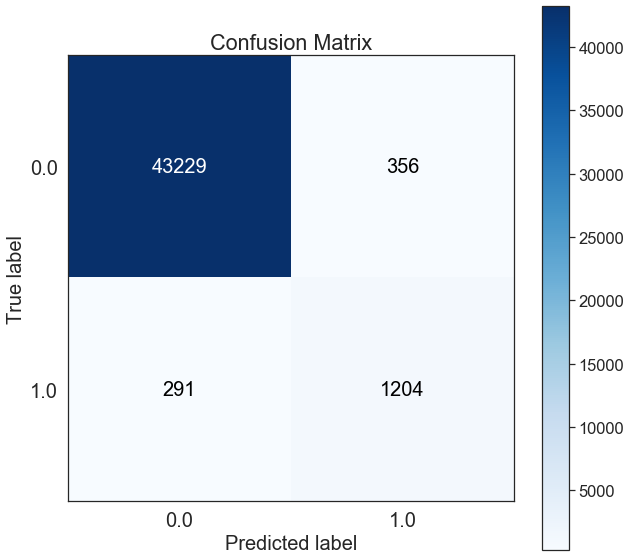

In [100]:
modified_ratio_uncombined_limited_xgb = ut.evaluation(grid_xgb, X_val_not_combined, y_val_not_combined)

### ADABoost Gridsearch

In [101]:
# adaboost , also optimized for stacking applications
param_grid_ada = {'adaboostclassifier__algorithm':['SAMME.R',"SAMME"],
                  'adaboostclassifier__learning_rate':[0.02,0.05],
                 'adaboostclassifier__n_estimators':[100,200,500]}

In [102]:
ada_clf = AdaBoostClassifier(random_state=seed)
model_ada = make_pipeline(preprocessor_not_combined_limited,ada_clf)

In [103]:
grid_ada = GridSearchCV(model_ada, param_grid_ada, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_ada.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_ada.best_params_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  48 | elapsed:  2.2min remaining:   55.2s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  3.0min finished


{'adaboostclassifier__algorithm': 'SAMME', 'adaboostclassifier__learning_rate': 0.02, 'adaboostclassifier__n_estimators': 100}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     43585
         1.0       0.78      0.77      0.77      1495

    accuracy                           0.99     45080
   macro avg       0.88      0.88      0.88     45080
weighted avg       0.98      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :40.0
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 75 is :44.35
Ratio of modified Reads for ref_pos 81 is :32.61
Ratio of modified Reads for ref_pos 104 is :43.48
Ratio of modified Reads for ref_pos 123 is :42.17
Ratio of modified Reads for ref_pos 163 is :33.91
Ratio of modified Reads for ref_pos 179 is :43.91
Ratio of modified Reads for ref_pos 185 is :32.17
------------------------------


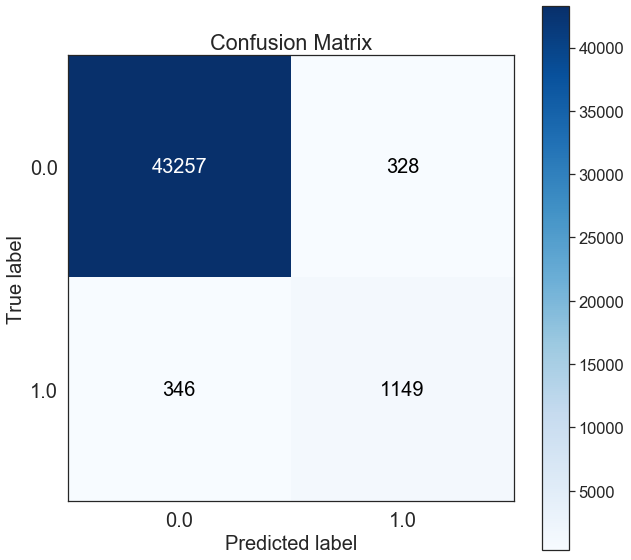

In [104]:
modified_ratio_uncombined_limited_ada = ut.evaluation(grid_ada, X_val_not_combined, y_val_not_combined)

### Random Forest

In [105]:
# random forest also optimized for stacking applications
param_grid_rf = {'randomforestclassifier__n_estimators':[250],
                  'randomforestclassifier__criterion':["entropy"],
                 'randomforestclassifier__max_depth':[5],
                'randomforestclassifier__min_samples_split':[5],
                'randomforestclassifier__min_samples_leaf':[2]}

In [106]:
rf_clf = RandomForestClassifier(random_state=seed)
model_rf = make_pipeline(preprocessor_not_combined_limited,rf_clf)

In [107]:
grid_rf = GridSearchCV(model_rf, param_grid_rf, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)
grid_rf.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_rf.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   30.8s finished


{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 250}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     43585
         1.0       0.77      0.82      0.79      1495

    accuracy                           0.99     45080
   macro avg       0.88      0.90      0.89     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :43.91
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :32.17
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :39.13
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :41.3
Ratio of modified Reads for ref_pos 163 is :38.26
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified Reads for ref_pos 185 is :38.26
-------------------

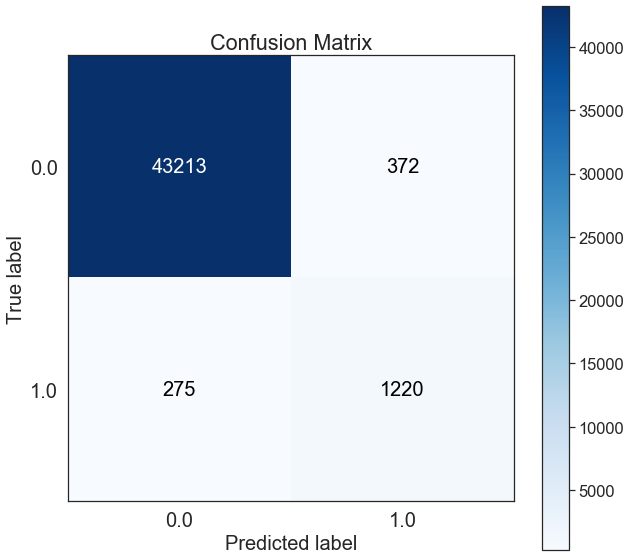

In [108]:
modified_ratio_uncombined_limited_rf = ut.evaluation(grid_rf, X_val_not_combined, y_val_not_combined)

### SVC

In [109]:
# svc also optimized for stacking applications
param_grid_svc = {'svc__C':[5.0],
                  'svc__kernel':["rbf"]}

In [110]:
svc_clf = SVC(random_state=seed)
model_svc = make_pipeline(preprocessor_not_combined_limited,svc_clf)

In [111]:
grid_svc = GridSearchCV(model_svc, param_grid_svc, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)

In [112]:
grid_svc.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_svc.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  4.8min finished


{'svc__C': 5.0, 'svc__kernel': 'rbf'}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     43585
         1.0       0.77      0.81      0.79      1495

    accuracy                           0.99     45080
   macro avg       0.88      0.90      0.89     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :43.91
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :30.43
Ratio of modified Reads for ref_pos 75 is :44.78
Ratio of modified Reads for ref_pos 81 is :34.35
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :42.17
Ratio of modified Reads for ref_pos 163 is :39.57
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified Reads for ref_pos 185 is :36.09
------------------

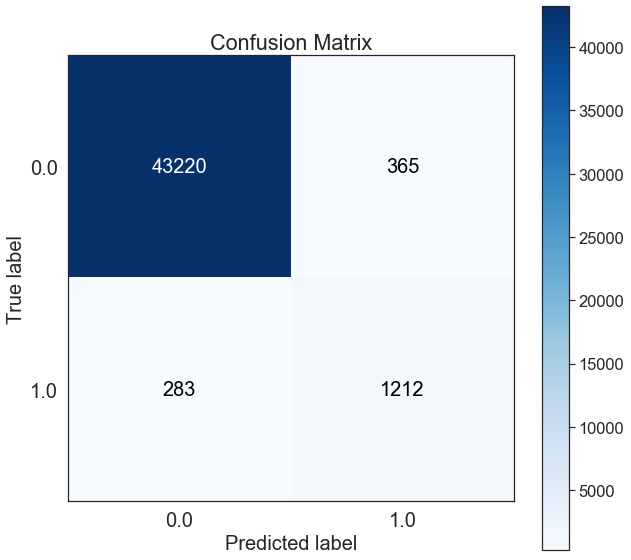

In [113]:
modified_ratio_uncombined_limited_svc = ut.evaluation(grid_svc, X_val_not_combined, y_val_not_combined)

### KNN

In [114]:
# knn also optimized for stacking applications
param_grid_knn = {'kneighborsclassifier__n_neighbors':[45],
                  'kneighborsclassifier__algorithm':["auto"],
                 'kneighborsclassifier__p':[1]}

In [115]:
knn_clf = KNeighborsClassifier()
model_knn = make_pipeline(preprocessor_not_combined_limited,knn_clf)

In [116]:
grid_knn = GridSearchCV(model_knn, param_grid_knn, scoring = "f1", return_train_score=False,n_jobs=-1,cv = cv_by_hand, verbose=3)

In [117]:
grid_knn.fit(X_finaltest_not_combined, y_finaltest_not_combined)
print(grid_knn.best_params_)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.0s finished


{'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 45, 'kneighborsclassifier__p': 1}


------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     43585
         1.0       0.77      0.82      0.79      1495

    accuracy                           0.99     45080
   macro avg       0.88      0.91      0.89     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :43.91
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 65 is :31.3
Ratio of modified Reads for ref_pos 75 is :44.78
Ratio of modified Reads for ref_pos 81 is :37.83
Ratio of modified Reads for ref_pos 104 is :44.78
Ratio of modified Reads for ref_pos 123 is :42.17
Ratio of modified Reads for ref_pos 163 is :39.13
Ratio of modified Reads for ref_pos 169 is :30.87
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified R

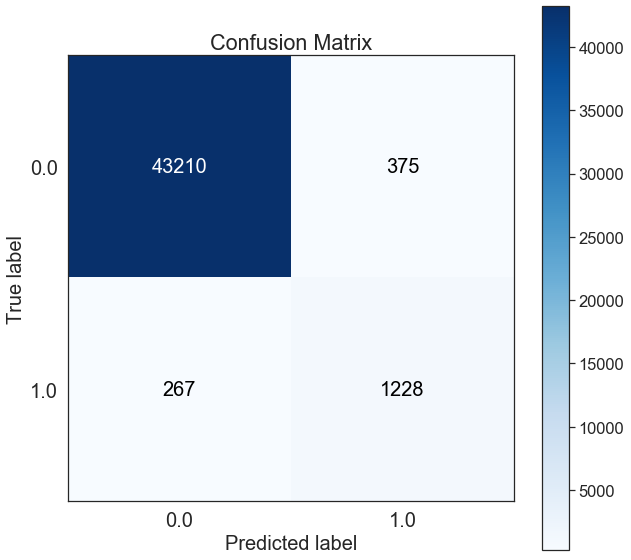

In [118]:
modified_ratio_uncombined_limited_knn = ut.evaluation(grid_knn, X_val_not_combined, y_val_not_combined)

### feature importances

In [119]:
xgb = XGBClassifier(n_jobs=-1,random_state=seed, gamma = 0, learning_rate = 0.1, max_depth = 1, n_estimators = 500)

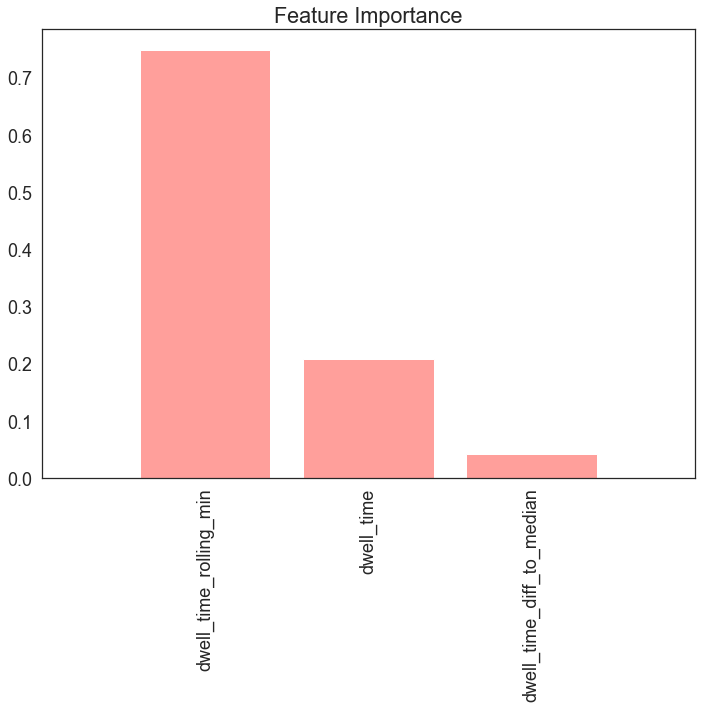

In [120]:
ut.feature_importances(xgb, preprocessor_not_combined_limited, X_finaltest_not_combined, y_finaltest_not_combined, 
                    custom_feature_state=True, custom_feature_list = numeric_features_limited)

### Stacking

In [121]:
# stacking for best models
rf_clf = RandomForestClassifier(random_state=seed,n_jobs=-1, criterion="entropy", max_depth= 5, min_samples_leaf= 2, 
                                min_samples_split= 5, n_estimators= 250)
model_rf = make_pipeline(preprocessor_not_combined_limited,rf_clf)

In [122]:
xgb_clf = XGBClassifier(n_jobs=-1,random_state=seed, max_depth=1, learning_rate=0.1, n_estimators=500, gamma=0)
model_xgb = make_pipeline(preprocessor_not_combined_limited,xgb_clf)

In [123]:
ada_clf = AdaBoostClassifier(random_state=seed, n_estimators=100, learning_rate=0.02, algorithm = "SAMME")
model_ada = make_pipeline(preprocessor_not_combined_limited,ada_clf)

In [124]:
svc_clf = SVC(random_state=seed,C= 5.0, kernel= 'rbf')
model_svc = make_pipeline(preprocessor_not_combined_limited,svc_clf)

In [125]:
knn_clf = KNeighborsClassifier(algorithm="auto", n_neighbors = 45, p = 1)
model_knn = make_pipeline(preprocessor_not_combined_limited,knn_clf)

In [126]:
estimators = [("XGB", model_xgb),("ADA",model_ada),("RF",model_rf),("SVC", model_svc),("KNN", model_knn)]
stack_clf = StackingClassifier(estimators, cv = cv_by_hand, final_estimator = LogisticRegression(), n_jobs=-1)

In [127]:
%%capture
stack_clf.fit(X_finaltest_not_combined, y_finaltest_not_combined)

------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     43585
         1.0       0.78      0.81      0.79      1495

    accuracy                           0.99     45080
   macro avg       0.88      0.90      0.89     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :42.61
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 75 is :45.22
Ratio of modified Reads for ref_pos 81 is :36.09
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :42.17
Ratio of modified Reads for ref_pos 163 is :36.96
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified Reads for ref_pos 185 is :37.83
------------------------------


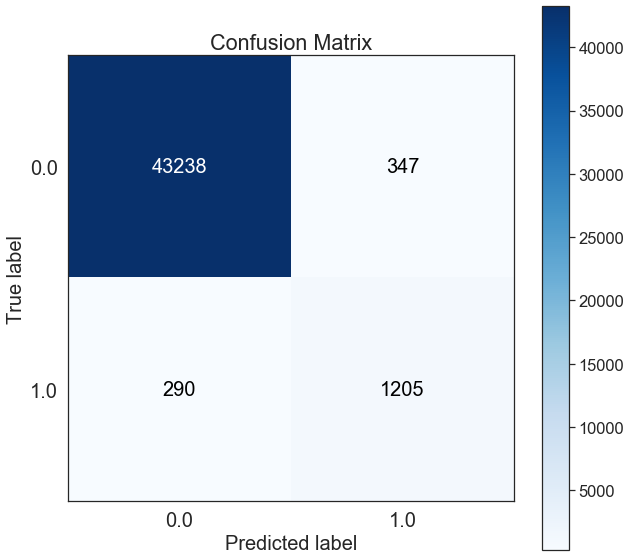

In [128]:
modified_ratio_uncombined_limited_stack = ut.evaluation(stack_clf, X_val_not_combined, y_val_not_combined)

### Voting

In [129]:
# voting approach for  best models
vote_clf = VotingClassifier(estimators, n_jobs=-1, voting='hard')

In [130]:
%%capture
vote_clf.fit(X_finaltest_not_combined, y_finaltest_not_combined)

------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     43585
         1.0       0.77      0.81      0.79      1495

    accuracy                           0.99     45080
   macro avg       0.88      0.90      0.89     45080
weighted avg       0.99      0.99      0.99     45080

------------------------------
Ratio of modified Reads for ref_pos 15 is :45.22
Ratio of modified Reads for ref_pos 26 is :43.48
Ratio of modified Reads for ref_pos 43 is :45.22
Ratio of modified Reads for ref_pos 58 is :45.22
Ratio of modified Reads for ref_pos 75 is :44.78
Ratio of modified Reads for ref_pos 81 is :35.22
Ratio of modified Reads for ref_pos 104 is :45.22
Ratio of modified Reads for ref_pos 123 is :42.61
Ratio of modified Reads for ref_pos 163 is :38.26
Ratio of modified Reads for ref_pos 179 is :45.22
Ratio of modified Reads for ref_pos 185 is :36.52
------------------------------


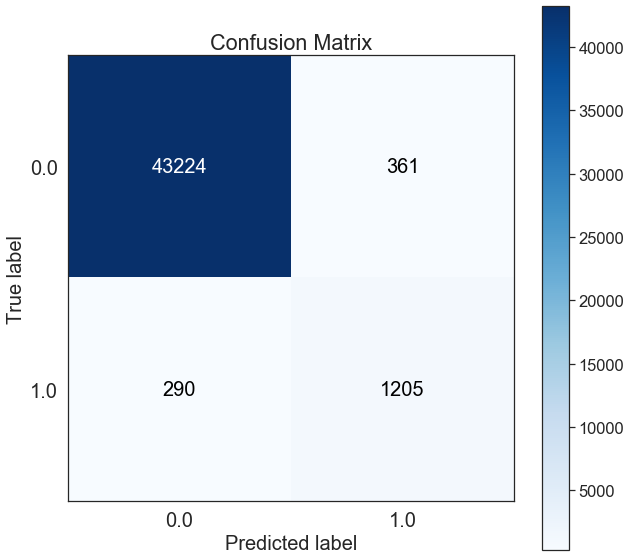

In [131]:
modified_ratio_uncombined_limited_vote = ut.evaluation(vote_clf, X_val_not_combined, y_val_not_combined)

In [132]:
# stacking and voting do not improve f1 score on limited dataset over single xgboost

### yeast dataset

In [135]:
# limited approach brings further improvement to yeast data prediction

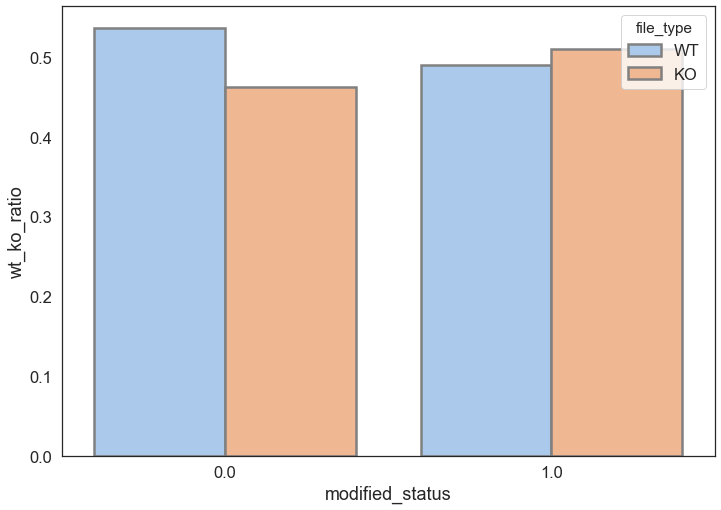

In [136]:
temp = ut.yeast_prediction(preprocessor_not_combined_limited, X_finaltest_not_combined, 
                 y_finaltest_not_combined, df_yeast_not_combined, xgb, "Not Combined Limited")
yeast_prediction_results = pd.concat([yeast_prediction_results,temp], axis=0)

In [137]:
yeast_prediction_results

wt_ko_ratio
Model                      modified_status file_type             
Not Combined               0.0             KO            0.463482
                                           WT            0.536518
                           1.0             KO            0.476433
                                           WT            0.523567
Not Combined without Bases 0.0             KO            0.463302
                                           WT            0.536698
                           1.0             KO            0.504897
                                           WT            0.495103
Not Combined Limited       0.0             KO            0.463245
                                           WT            0.536755
                           1.0             KO            0.509681
                                           WT            0.490319

In [138]:
model_selection_results

test_result
instance_name                                  test           model             
Uncombined Dataframe                           test_precision RF        0.960134
                                                              SVC       0.943923
                                                              XGB       0.925804
                                               test_recall    GNB       1.000000
                                                              XGB       0.833907
                                                              ADAB      0.807188
                                               test_f1score   XGB       0.876514
                                                              ADAB      0.849270
                                                              LR        0.812891
                                               test_roc auc   ADAB      0.987870
                                                              XGB       0.986505
                                                              LR        0.985274
Uncombined Dataframe and Oversampling          test_precision RF        0.960134
                                                              SVC       0.943923
                                                              XGB       0.925804
                                               test_recall    GNB       1.000000
                                                              XGB       0.833907
                                                              ADAB      0.807188
                                               test_f1score   XGB       0.876514
                                                              ADAB      0.849270
                                                              LR        0.812891
                                               test_roc auc   ADAB      0.987870
                                                              XGB       0.986505
                                                              LR        0.985274
Uncombined Dataframe and Polynomial Dwell Time test_precision RF        0.955756
                                                              SVC       0.940471
                                                              XGB       0.925804
                                               test_recall    GNB       1.000000
                                                              XGB       0.833907
                                                              ADAB      0.807188
                                               test_f1score   XGB       0.876514
                                                              ADAB      0.849270
                                                              SVC       0.835547
                                               test_roc auc   ADAB      0.987870
                                                              XGB       0.986505
                                                              LR        0.985589
Uncombined Dataframe without bases             test_precision MLP       0.839864
                                                              RF        0.838160
                                                              SVC       0.824395
                                               test_recall    GNB       0.874954
                                                              XGB       0.764874
                                                              ADAB      0.727549
                                               test_f1score   XGB       0.784507
                                                              SVC       0.767294
                                                              ADAB      0.761202
                                               test_roc auc   MLP       0.965020
                                                              XGB       0.960405
                                                              ADAB      0.957208
Uncombined Datafram